# VFRForWeb

VFRForWeb performs improved visual font recognition for the aim of improving the web development workflow currently commonplace.
Explanations are provided below for each part of the code, and results are elaborated on later in the notebook.

## Import libraries

Add required imports such as:

- TensorFlow 2.0, most widely-used Deep Learning framework, in its most recent version

- TensorFlow Datasets, the most convenient API for researchers to import entire public datasets, regardless of structure, in  only a few lines of code. The AdobeVFR dataset was personally contributed to this API and further used in this work.

- matplotlib, for plotting images and statistics

- imgaug, for image augmentation / preprocessing, for improving the learning curve of the model and reduce overfitting

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

In [2]:
# !pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

keras = tf.keras
print("Tensorflow version", tf.__version__)
print("Eager execution enabled:", tf.executing_eagerly())

Tensorflow version 2.0.0-dev20190510
Eager execution enabled: True


## Data preprocessing

The dataset, which represents the entire collection of images used to train and validate the model, is downloaded and managed via Tensorflow Datasets, for which a contribution was made to have AdobeVFR available in the API.

In [3]:
import sys
sys.path.insert(0, '/data2/python_packages/tf_datasets')
import tensorflow_datasets as tfds

Loading AdobeVFR


The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object, which can be used to shuffle, batch and repeat images from each dataset for training and evaluation..

The import of AdobeVFR made to Tensorflow Datasets does not have any predefined splits except for training, therefore the entire dataset will be loaded and splitted manually in 80% training, 20% validation.

In [4]:
SPLIT_WEIGHTS = (8, 2)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation), metadata = tfds.load(name="adobe_vfr", 
                                                    with_info=True,
                                                    split=list(splits),
                                                    as_supervised=True)

Getting labels from fontlist.txt


As it can be observed in the code above, the entire complexity of importing the dataset (hich becomes even more difficult as the images are stored [originally in BCF Format](https://www.dropbox.com/sh/o320sowg790cxpe/AAAJr15UkGQ7vEG9YitS2ETma/BCF%20format?dl=0&subfolder_nav_tracking=1)) is completely hidden from users which would only have to use the `.load()` method to import the dataset and its related information, such as number of labels, images, etc.

To be more specific, the [Adding a dataset](https://github.com/tensorflow/datasets/blob/master/docs/add_dataset.md) guideline was followed and a Python script was created which processes the BCF images and labels separately, joins them together as tuples, and returns them as a `Dataset` object.

In [5]:
# print(raw_data)
# NUM_CLASSES = metadata.features["label"].num_classes
# train_split = tf.cast(SPLIT_WEIGHTS[0] / 10 * IMAGES_PER_FONT, tf.int64)
# val_split = tf.cast(SPLIT_WEIGHTS[1] / 10 * IMAGES_PER_FONT, tf.int64)
# IMAGES_PER_FONT = 1000

# raw_train = raw_data.take(train_split)
# raw_validation = raw_data.skip(train_split).take(val_split)
# print(raw_train)
# print(raw_validation)
# print("There are", NUM_CLASSES, "font classes.")
# for i in range(IMAGES_PER_FONT, NUM_CLASSES * IMAGES_PER_FONT, IMAGES_PER_FONT):
#     raw_train = raw_train.concatenate(raw_data.skip(i).take(train_split))
#     raw_validation = raw_val.concatenate(raw_data.skip(i + train_split).take(val_split))
#     print(i)
#     print(train_split)
#     print(val_split)

# i = 0
# for image, label in raw_data.take(1000):
#     print(i, label)
#     i += 1

The resulting `tf.data.Dataset` objects contain `(image, label)` pairs. Where the images have variable shape and 3 channels, and the label is an integer representing the index of the font from fontlist.txt file.

In [6]:
print(raw_train)
print(raw_validation)
# print(raw_test)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


Create the imgaug augmentator and show two random unaugmented images from the training set.
Augmentation is done with random parameters which help train the model to idenfity font in more difficult scenarios, such as font distortion, blur and noise, and perspective transforms.

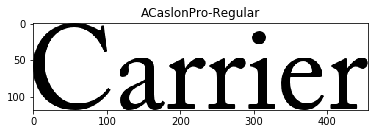

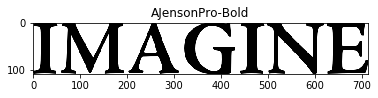

In [7]:
import imageio
import imgaug as ia
from matplotlib import pyplot
from imgaug import augmenters as iaa
import random
%matplotlib inline

seq = iaa.Sequential([
        iaa.AdditiveGaussianNoise(scale=(0.03, 128)),
        iaa.GaussianBlur(sigma=1),
#        iaa.Affine(rotate=(-10, 10)),
        iaa.PerspectiveTransform(0.025),
#         iaa.Invert(p=1),
        iaa.Resize({"height":105, "width":"keep-aspect-ratio"}),
        iaa.CropToFixedSize(105, 105),
        iaa.Resize({"height":105, "width":105}),
])

NUM_CLASSES = metadata.features['label'].num_classes

get_label_name = metadata.features['label'].int2str

for image, label in raw_train.skip(random.randint(0, NUM_CLASSES * 1000 - 10)).take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

def augment_images(image):
    image_aug = seq.augment_image(image)
    return image_aug

The `format_example` function is defined to get the original images from TensorFlow, convert them to the required format (from `float32` values to `uint8`) and return as randomly augmented images. 

In [8]:
IMG_SIZE = 105 # All images will be resized to 105x105

def format_example(image, label):
  image = tf.cast(image, tf.uint8)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  image = tf.py_function(func=augment_images, inp=[image], Tout=tf.uint8)
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label 


The function is then mapped to the entire dataset splits of training and validation.

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)

In [10]:
# for image, label in train.skip(random.randint(0, NUM_CLASSES * 800 - 10)).take(2):
# #   image_aug = seq.augment_image(image)
# #   image = tf.cast(image, tf.float32)
# #   image = (image/127.5) - 1
# #   image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
#   plt.figure()
# #   plt.imshow(image.numpy().astype(np.uint8))
#   plt.imshow(image.numpy())
#   plt.title(get_label_name(label))

In [11]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000

For even better feature detection and overfitting reduction, the original images are repeated 10 times and augmented differently.

In [12]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).repeat(10).batch(BATCH_SIZE)
validation_batches = validation.repeat(10).batch(BATCH_SIZE)

Check the shape of a image from batch (testing purposes only). The result Tensor resembles an array of 128 images of size 105x105 with RGB colouring (3 channels).

In [13]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([128, 105, 105, 3])

## Create the model from scratch
The final and best performing model is a convolutional neural network with 11 layers (convolutional and max pooling layers), plus other significant new features introduced over the DeepFont model, such as Xavier weight initialisation, batch normalisation layers, and custom dropout rates on the last layers to reduce overfitting of the model. As some of these features represent the default paramaters in Keras, they are not present in the code below but can be inspected customarily by printing the details of each layer.

The model is built using Tensorflow 2.0 alpha, which is a significant improvement over the version 1 predecessor, and incorporates the Keras Deep Learning API by default. A previous model was also attempted to be created with PyTorch (an alternative to Keras / TensorFlow), although the results were not satisfactory and therefore disregarded. More information is available further down in the notebook.

In [14]:
NUM_CLASSES = metadata.features["label"].num_classes

model = keras.models.Sequential([
    keras.layers.Conv2D(64, input_shape=(105, 105, 3), kernel_size=11, strides=(2, 2), padding='valid', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'),
    
    keras.layers.Conv2D(64, kernel_size=5, strides=(1, 1), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'),

    keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),
    keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),
    keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),

    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


def lr_decay_callback(lr_init, lr_decay):
    def step_decay(epoch):
        return lr_init * (lr_decay ** (epoch + 1))
    return keras.callbacks.LearningRateScheduler(step_decay)

# lr_decay = lr_decay_callback(0.01, lr_decay)

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.SGD(lr=base_learning_rate),
              loss='sparse_categorical_crossentropy',
#               momentum=0.9,
#               decay=0.0005,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        23296     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 256)       1

## Train the model

In the code below, firstly the previously trained model is loaded from the saved H5 file, which includes the model architecture, the weights of layers, and the highest accuracy gained. The model also benefits from custom callbacks for saving the model through checkpoints when the accuracy improves, and for automatically stopping the model from training when it does not improve over 20 epochs.

An epoch represents an entire run over the training dataset.

In [15]:
model = keras.models.load_model('../vfr_model_final.h5')

In [ ]:
 # We use this variable for statistical purposes, to show continuity over the previous training phase where possible
fine_tune_epochs = 200
initial_epochs = 21
total_epochs =  initial_epochs + fine_tune_epochs

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=20)
checkpoint_callback = keras.callbacks.ModelCheckpoint('vfr_model_final.h5', monitor='accuracy', verbose=1, save_best_only=True, mode='max')

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = initial_epochs,
                         validation_data=validation_batches,
                         callbacks=[early_stopping_callback, checkpoint_callback])

## Evaluation

For evaluating the model, the common approach used for evaluating image classification neural networks is used: check the number of fonts which were correctly recognised in the top-1 prediction (i.e. the model is most sure that is the font in the image) and similarly for top-5 prediction (i.e. check whether the correct font is one of the 5 that the model predicted to be the most likely present in the image).

In [17]:
top1 = 0.0
top5 = 0.0
get_label_index = metadata.features["label"].str2int
num_labels = metadata.features["label"].num_classes
print("Total number of classes:", num_labels)
NUM_TESTS = 3000
for image, label in validation.take(NUM_TESTS):
    class_probs = model.predict(np.expand_dims(image, axis=0), 1)
    l = label
    class_prob = class_probs[0][:num_labels]
    top_values = (-class_prob).argsort()[:5]
#     print("Top 1 prediction:", top_values[0])
#     print("Correct font:", l.numpy(), " - ", get_label_name(l))
    if top_values[0] == l.numpy():
#         print("Correct top-1 font")
        top1 += 1.0
    if np.isin(np.array([l.numpy()]), top_values):
#         print("Correct top-5 font")
        top5 += 1.0

print()
print("Correctly recognised top-1 fonts:", top1/NUM_TESTS)
print("Correctly recognised top-5 fonts", top5/NUM_TESTS)

Total number of classes: 20

Correctly recognised top-1 fonts: 0.9816666666666667
Correctly recognised top-5 fonts 0.999


### Test images manually

The following code can be used to predict a font from a manually inserted image. This code could therefore be wrapped in a web framework such as Flask and be offered as an online web service such as WhatTheFont, IdentiFont, FontSquirrel, etc.

Text(0.5, 1.0, 'Processed')

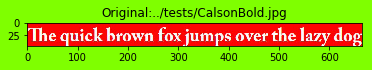

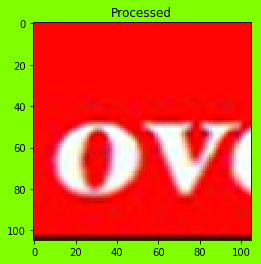

In [25]:
from PIL import Image

crop_seq = iaa.Sequential([
        iaa.PerspectiveTransform(0.025),
        iaa.Resize({"height":105, "width":"keep-aspect-ratio"}),
        iaa.CropToFixedSize(105, 105),
        iaa.Resize({"height":105, "width":105}),
])
def crop_image(image):
    image_aug = crop_seq.augment_image(image)
    return image_aug

im = Image.open("../tests/CalsonBold.jpg")
test_image = crop_image(np.array(im))
plt.figure(facecolor='chartreuse')
plt.imshow(im)
plt.title("Original:" + im.filename)
plt.figure(facecolor='chartreuse')
plt.imshow(test_image)
plt.title("Processed")

In [26]:
top1 = 0.0
top5 = 0.0
get_label_index = metadata.features["label"].str2int
num_labels = metadata.features["label"].num_classes
print("Total number of classes:", num_labels)
class_probs = model.predict(np.expand_dims(test_image, axis=0), 1)
NUM_TESTS = 1
l = 14
for i in range(len(class_probs)):
    class_prob = class_probs[i][:num_labels]
    top_values = (-class_prob).argsort()[:5]
    print("Correct font:", l, " - ", get_label_name(l))
    if top_values[0] == l:
        top1 += 1.0
    if np.isin(np.array([l]), top_values):
        top5 += 1.0

print()
print("Predictions: ")
for i in top_values:
    prediction = class_probs[0][i]
    print(get_label_name(i))

print()
print("Matched in top-1:", top1/NUM_TESTS)
print("Matched in top-5:", top5/NUM_TESTS)

Total number of classes: 20
Correct font: 14  -  AJensonPro-BoldDisp

Predictions: 
AJensonPro-BoldDisp
AJensonPro-BoldItDisp
ACaslonPro-Bold
AJensonPro-BoldItCapt
AJensonPro-BoldIt

Matched in top-1: 1.0
Matched in top-5: 1.0


In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Other attempts

#### Creating the base model from the pre-trained convnets

The code below makes use of VGG16 a well-known architecture used in the ImageNet Large Scale Visual Recognition Competition (ILSVRC) in 2014, which won the competition by achieving the lowest error rates at the time of classifying 14 million images over 1000 classes through a state-of-the-art CNN architecture. On top of VGG16, the output of the CNN was flattened and connected to Multilayer Peceptrons (MLPs, Dense layers in Keras) which allow identifying the features in each of the fonts.

Due to its deeper CNN architecture (which allows the model to gather more detailed features) and having already been trained over a very large image classification dataset, the model seemed promising for being fine-tuned for VFR, though the results have not been satisfactory even after a reasonable amount of iterations.

The model achieved 63% top-1 accuracy after 60 epochs, compared to 90%+ over only 5 epochs for the proposed solution.

In [72]:
saved_model = keras.models.load_model('vfr_model_c.h5')
# saved_model.name = "VFR"

In [73]:
# new_layers = []
# for i in range(4):
#     new_layers.add()
# # Load weights of previous output layer, set weights for new layer
# old_layer_weights = saved_model.layers.pop().get_weights()
# new_neuron_weights = np.ndarray(shape=[1,0])

# # Set new weights

# # Append new weights, add new layer
# new_layer = keras.layers.Dense(NUM_CLASSES)#.set_weights(np.append(old_layer_weights,new_neuron_weights))
# saved_model.add(new_layer)

# for i in range(6):
# dense1 = keras.layers.Dense(NUM_CLASSES)(saved_model.layers[-1].output)
# saved_model.add(dense1)
# saved_model.add(dense1)
# # 3rd Fully Connected Layer
# saved_model.add(keras.layers.Dense(NUM_CLASSES))
# saved_model.add(keras.layers.Activation('relu'))
# # Add Dropout
# saved_model.add(keras.layers.Dropout(0.4))

# # Output Layer
# saved_model.add(keras.layers.Dense(NUM_CLASSES))
# saved_model.add(keras.layers.Activation('softmax'))

# saved_model._layers[0].Input  = (None, 105, 105, 1)
saved_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              18878464  
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
activation_1 (Activation)    (None, 4096)              0

## Other attempts
The following architecture is based on VGG16. 

In [ ]:
fine_tune_epochs = 100
initial_epochs = 36
total_epochs =  initial_epochs + fine_tune_epochs

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint_callback = keras.callbacks.ModelCheckpoint('vfr_model_c.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history_fine = saved_model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = initial_epochs,
                         validation_data=validation_batches,
                         callbacks=[early_stopping_callback, checkpoint_callback])


Epoch 37/136
   1250/Unknown - 1388s 1s/step - loss: 1.1569 - accuracy: 0.5917
Epoch 00037: val_loss improved from inf to 1.40803, saving model to vfr_model_c.h5
1250/1250 [==============================] - 1731s 1s/step - loss: 1.1569 - accuracy: 0.5917 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 38/136
1249/1250 [============================>.] - ETA: 1s - loss: 1.1480 - accuracy: 0.5965
Epoch 00038: val_loss improved from 1.40803 to 1.34804, saving model to vfr_model_c.h5
1250/1250 [==============================] - 1732s 1s/step - loss: 1.1481 - accuracy: 0.5964 - val_loss: 1.3480 - val_accuracy: 0.5241
Epoch 39/136
1249/1250 [============================>.] - ETA: 1s - loss: 1.1398 - accuracy: 0.6002
Epoch 00039: val_loss did not improve from 1.34804
1250/1250 [==============================] - 1729s 1s/step - loss: 1.1399 - accuracy: 0.6001 - val_loss: 1.3694 - val_accuracy: 0.5136
Epoch 40/136
1249/1250 [============================>.] - ETA: 1s - loss: 1.1253 - accu

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1249/1250 [============================>.] - ETA: 1s - loss: 1.0848 - accuracy: 0.6236
Epoch 00049: val_loss improved from 1.30209 to 1.27676, saving model to vfr_model_c.h5
1250/1250 [==============================] - 1721s 1s/step - loss: 1.0847 - accuracy: 0.6237 - val_loss: 1.2768 - val_accuracy: 0.5318
Epoch 50/136
1249/1250 [============================>.] - ETA: 1s - loss: 1.0807 - accuracy: 0.6247
Epoch 00050: val_loss improved from 1.27676 to 1.25943, saving model to vfr_model_c.h5
1250/1250 [==============================] - 1722s 1s/step - loss: 1.0808 - accuracy: 0.6246 - val_loss: 1.2594 - val_accuracy: 0.5528
Epoch 51/136
 632/1250 [==============>...............] - ETA: 11:30 - loss: 1.0733 - accuracy: 0.6272

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1249/1250 [============================>.] - ETA: 1s - loss: 1.0633 - accuracy: 0.6319
Epoch 00053: val_loss did not improve from 1.25943
1250/1250 [==============================] - 1721s 1s/step - loss: 1.0633 - accuracy: 0.6320 - val_loss: 1.3965 - val_accuracy: 0.4879
Epoch 54/136
1249/1250 [============================>.] - ETA: 1s - loss: 1.0703 - accuracy: 0.6283
Epoch 00054: val_loss did not improve from 1.25943
1250/1250 [==============================] - 1721s 1s/step - loss: 1.0703 - accuracy: 0.6283 - val_loss: 1.3733 - val_accuracy: 0.5002
Epoch 55/136
1249/1250 [============================>.] - ETA: 1s - loss: 1.0575 - accuracy: 0.6309
Epoch 00055: val_loss improved from 1.25943 to 1.23619, saving model to vfr_model_c.h5
1250/1250 [==============================] - 1725s 1s/step - loss: 1.0575 - accuracy: 0.6309 - val_loss: 1.2362 - val_accuracy: 0.5535
Epoch 56/136
1249/1250 [============================>.] - ETA: 1s - loss: 1.0592 - accuracy: 0.6306
Epoch 00056: val_lo

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Other experiments

Below code is only kept for reference purposes.

Text(0.5, 1.0, 'Processed')

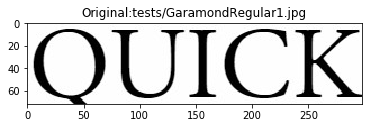

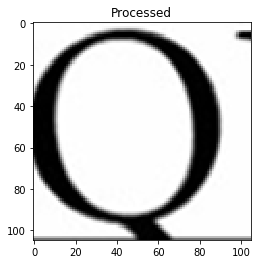

In [30]:
from PIL import Image

crop_seq = iaa.Sequential([
#         iaa.AdditiveGaussianNoise(scale=(0.03, 128)),
#         iaa.GaussianBlur(sigma=1),
#        iaa.Affine(rotate=(-10, 10)),
        iaa.PerspectiveTransform(0.025),
#         iaa.Invert(p=1),
#         iaa.Resize({"height":400, "width":700}),
        iaa.Resize({"height":105, "width":"keep-aspect-ratio"}),
        iaa.CropToFixedSize(105, 105),
        iaa.Resize({"height":105, "width":105}),
#        iaa.CropToFixedSize(height=320,width=320)
])
def crop_image(image):
    image_aug = crop_seq.augment_image(image)
#     print(image_aug.dtype)
    return image_aug

im = Image.open("tests/GaramondRegular1.jpg")
test_image = crop_image(np.array(im))
plt.figure()
#   plt.imshow(image.numpy().astype(np.uint8))
# print(im)
plt.imshow(im)
plt.title("Original:" + im.filename)
plt.figure()
plt.imshow(test_image)
plt.title("Processed")

In [ ]:
top1 = 0.0
top5 = 0.0
get_label_index = metadata.features["label"].str2int
num_labels = metadata.features["label"].num_classes
class_probs = saved_model.predict(np.expand_dims(test_image, axis=0), 1)
# print(class_probs)
print("Total number of classes:", num_labels)
for i in range(num_labels):
    l = i
    class_prob = class_probs[0][:num_labels]
    top_values = (-class_prob).argsort()[:5]
#     print(top_values)
    if top_values[0] == l:
        top1 += 1.0
    if np.isin(np.array([l]), top_values):
        top5 += 1.0

print()
print("Predictions: ")
for i in top_values:
    prediction = class_probs[0][i]
    print(get_label_name(i), round(prediction, 5))

print()
print("top1 acc", top1/num_labels)
print("top5 acc", top5/num_labels)

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image to a `5x5x1280` block of features. See what it does to the example batch of images:

In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

## Feature extraction
You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It's important to freeze the convolutional based before you compile and train the model. By freezing (or setting `layer.trainable = False`), you prevent the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to `False` will freeze all the layers.

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()
# Get the top, pre-trained part of VGG16
pretrained_top = base_model.layers[-4:]
# print(pretrained_top)

### Add a classification head

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
prediction_layer = keras.layers.Dense(20)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [ ]:
model = tf.keras.Sequential([
    keras.layers.Conv2D(filters=256, input_shape=(105, 105, 3), kernel_size=(3,3), strides=(9, 9)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'), 
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),    
#     *pretrained_top,
#     keras.layers.MaxPool2D(),
    # Passing it to a Fully Connected layer
    keras.layers.Flatten(),
    # 1st Fully Connected Layer
    keras.layers.Dense(4096),
    keras.layers.Activation('relu'),
    # Add Dropout to prevent overfitting
    keras.layers.Dropout(0.4),

    # 2nd Fully Connected Layer
    keras.layers.Dense(4096),
    keras.layers.Activation('relu'),
    # Add Dropout
    keras.layers.Dropout(0.4),

    # 3rd Fully Connected Layer
    keras.layers.Dense(NUM_OF_CLASSES),
    keras.layers.Activation('relu'),
    # Add Dropout
    keras.layers.Dropout(0.4),

    # Output Layer
    keras.layers.Dense(NUM_OF_CLASSES),
    keras.layers.Activation('softmax'),
    
#   keras.layers.Conv2D(256, kernel_size=12, input_shape=(105, 105, 3), strides=(8, 8), kernel_initializer='glorot_uniform', bias_initializer='zeros'),
#   keras.layers.ReLU(),
#   keras.layers.Conv2D(256, kernel_size=12, strides=(2, 2), kernel_initializer='glorot_uniform', bias_initializer='zeros'),
#   keras.layers.ReLU(),
#   keras.layers.Conv2D(256, kernel_size=12, strides=(1, 1), kernel_initializer='glorot_uniform', bias_initializer='zeros'),
#   keras.layers.ReLU(),
    
#   base_model,
#   global_average_layer,
#   prediction_layer
])

### Compile the model 

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.SGD(lr=base_learning_rate),
              loss='sparse_categorical_crossentropy',
#               momentum=0.9,
#               decay=0.0005,
              metrics=['accuracy'])

In [ ]:
model.summary()

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

### Train the model

After training for 10 epochs, you should see ~96% accuracy.

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [20]:
num_train, num_val = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

In [21]:
initial_epochs = 5
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 23s 1s/step - loss: 2.9956 - accuracy: 0.0543


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.00
initial accuracy: 0.05


In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [16]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [23]:
base_model.trainable = False

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# # Fine tune from this layer onwards
# # fine_tune_at = 100
# fine_tune_last_layers = 4

# # Unfreeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:-fine_tune_last_layers]:
#   print("Setting", layer, "to non-trainable")
#   layer.trainable = False
# print(base_model.summary())

Number of layers in the base model:  19


### Compile the model

Compile the model using a much lower training rate.

In [30]:
NUM_OF_CLASSES = metadata.features["label"].num_classes
# print(NUM_OF_CLASSES)
model = tf.keras.Sequential([
    base_model,  
#     *pretrained_top,
#     keras.layers.MaxPool2D(),
    # Passing it to a Fully Connected layer
    keras.layers.Flatten(),
    # 1st Fully Connected Layer
    keras.layers.Dense(4096),
    keras.layers.Activation('relu'),
    # Add Dropout to prevent overfitting
    keras.layers.Dropout(0.4),

    # 2nd Fully Connected Layer
    keras.layers.Dense(4096),
    keras.layers.Activation('relu'),
    # Add Dropout
    keras.layers.Dropout(0.4),

    # 3rd Fully Connected Layer
    keras.layers.Dense(NUM_OF_CLASSES),
    keras.layers.Activation('relu'),
    # Add Dropout
    keras.layers.Dropout(0.4),

    # Output Layer
    keras.layers.Dense(NUM_OF_CLASSES),
    keras.layers.Activation('softmax'),
])

# base_learning_rate = 0.01
# learning_rate = 0.0001
epochs = 50
# decay_rate = learning_rate / epochs
# momentum = 0.9
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.9
optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)
# optimizer = keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
#               optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 4096)              18878464  
_________________________________________________________________
activation_12 (Activation)   (None, 4096)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
activation_13 (Activation)   (None, 4096)             

In [32]:
len(model.trainable_variables)

8

### Continue Train the model

In [ ]:
fine_tune_epochs = 50
initial_epochs = 0
total_epochs =  initial_epochs + fine_tune_epochs

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint_callback = keras.callbacks.ModelCheckpoint('vfr_model_fine.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = initial_epochs,
                         validation_data=validation_batches,
                         callbacks=[early_stopping_callback, checkpoint_callback])


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()